# Transformers for NLP

This notebook demonstrates two natural language processing tasks using transformer models:

1.  **Text Similarity:** We use a pretrained BERT model to compute the semantic similarity between pairs of sentences using cosine similarity.
2.  **Sentiment Classification:** We fine-tune a pretrained RoBERTa model to classify text as either positive or negative. The notebook includes steps for data loading, preprocessing, model training, validation, and making predictions on unseen test data.

The notebook also includes visualizations of the text similarity matrix for a small set of sentences.

This notebook focuses more on the code itself as opposed to analyzing data and ensuring highest model accuracy.

In [9]:
# Import required libraries
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/task2/train/5001.txt  
  inflating: data/task2/train/5002.txt  
  inflating: data/task2/train/5003.txt  
  inflating: data/task2/train/5004.txt  
  inflating: data/task2/train/5005.txt  
  inflating: data/task2/train/5006.txt  
  inflating: data/task2/train/5007.txt  
  inflating: data/task2/train/5008.txt  
  inflating: data/task2/train/5009.txt  
  inflating: data/task2/train/5010.txt  
  inflating: data/task2/train/5011.txt  
  inflating: data/task2/train/5012.txt  
  inflating: data/task2/train/5013.txt  
  inflating: data/task2/train/5014.txt  
 extracting: data/task2/train/5015.txt  
  inflating: data/task2/train/5016.txt  
 extracting: data/task2/train/5017.txt  
  inflating: data/task2/train/5018.txt  
  inflating: data/task2/train/5019.txt  
 extracting: data/task2/train/5020.txt  
  inflating: data/task2/train/5021.txt  
 extracting: data/task2/train/5022.txt  
  inflating: data/task2/train/5023.txt  
  infl

## Text Similarity

In this section a function to compute text similarity for BERT embeddings based on cosine similarity is defined. The function takes a list of $n$ strings as its input and returns a similarity matrix $\in \mathbb{R}^{n \times n}$.

In [10]:
from typing import Iterable
from transformers import BertModel, BertTokenizer
from numpy.typing import NDArray
from sklearn.metrics.pairwise import cosine_similarity

def text_similarity(texts: Iterable[str], model: BertModel, tokenizer: BertTokenizer, device: torch.device) -> NDArray[np.float32]:
  model.eval()
  model.to(device)

  encoded = tokenizer(list(texts), padding=True, truncation=True, return_tensors='pt')

  input_ids = encoded['input_ids'].to(device)
  attention_mask = encoded['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    pooled = outputs.pooler_output.cpu().numpy()

  similarity = cosine_similarity(pooled).astype(np.float32)

  return similarity

Let's produce a similarity matrix for our data and print out how the matrix looks like.

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sentences = pd.read_csv('data/task1/sentences.csv', index_col=0)
similarity = text_similarity(sentences['sentences'].values.tolist(), model, tokenizer, device)
similarity_df = pd.DataFrame(similarity)
similarity_df

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.000000,0.967476,0.955700,0.955700,0.966714,0.966039,0.974096,0.972136,0.954901,0.971591,...,0.961267,0.990940,0.990940,0.959173,0.966714,0.948319,0.971996,0.989977,0.945263,0.995723
1,0.967476,1.000000,0.980831,0.980831,0.989301,0.989510,0.986703,0.984763,0.889432,0.986705,...,0.990340,0.960896,0.960896,0.981514,0.989301,0.873120,0.984829,0.982517,0.877335,0.973255
2,0.955700,0.980831,1.000000,1.000000,0.988922,0.994341,0.992449,0.996262,0.870888,0.994041,...,0.994800,0.948721,0.948721,0.999153,0.988922,0.854270,0.994541,0.979047,0.849384,0.966383
3,0.955700,0.980831,1.000000,1.000000,0.988922,0.994341,0.992449,0.996262,0.870888,0.994041,...,0.994800,0.948721,0.948721,0.999153,0.988922,0.854270,0.994541,0.979047,0.849384,0.966383
4,0.966714,0.989301,0.988922,0.988922,1.000000,0.992891,0.995103,0.993766,0.891234,0.995723,...,0.995622,0.963661,0.963661,0.989917,1.000000,0.880381,0.993139,0.987618,0.876936,0.975151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.948319,0.873120,0.854270,0.854270,0.880381,0.873102,0.892130,0.881695,0.985788,0.884924,...,0.861340,0.940800,0.940800,0.859377,0.880381,1.000000,0.882137,0.921009,0.988993,0.941180
196,0.971996,0.984829,0.994541,0.994541,0.993139,0.991922,0.996696,0.998673,0.896717,0.998478,...,0.993921,0.965392,0.965392,0.996417,0.993139,0.882137,1.000000,0.990395,0.879630,0.981376
197,0.989977,0.982517,0.979047,0.979047,0.987618,0.985075,0.990856,0.990594,0.931050,0.990168,...,0.983672,0.989175,0.989175,0.981050,0.987618,0.921009,0.990395,1.000000,0.918791,0.994347
198,0.945263,0.877335,0.849384,0.849384,0.876936,0.868452,0.889254,0.876384,0.991430,0.881352,...,0.859870,0.937030,0.937030,0.855080,0.876936,0.988993,0.879630,0.918791,1.000000,0.941437


Text similarity matrix can also be represented graphically with a heatmap. However, such visualization is most effective for a small number of texts to compare. For that purpose we make up three sentences and compare their simialrity.

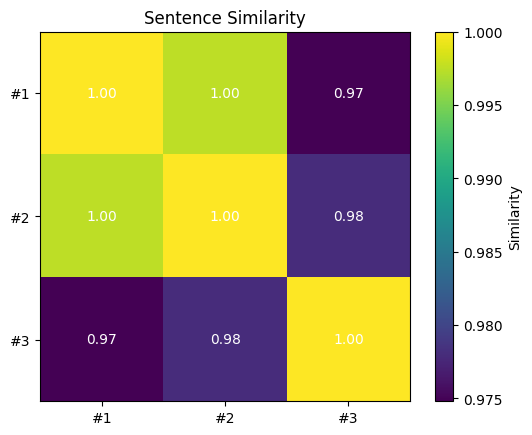

In [12]:
import matplotlib.pyplot as plt

sentences = [
    "Paul is cooking dinner for his friend.",
    "Maria is cooking dinner for her friend.",
    "Stockholm is a beautiful city!"
]

sim_matrix = text_similarity(sentences, model, tokenizer, device)

plt.imshow(sim_matrix, cmap="viridis")
plt.colorbar(label="Similarity")

n = len(sentences)
plt.xticks(range(n), [f"#{i+1}" for i in range(n)])
plt.yticks(range(n), [f"#{i+1}" for i in range(n)])

for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{sim_matrix[i, j]:.2f}", ha="center", va="center", color="white")

plt.title("Sentence Similarity")
plt.show()

We can see that the first and second sentences have a similarity of 1, in fact they are actually almost identical. The third sentence is also deemed very similar to the other two based on cosine similarity metric.

## Fine-tuning RoBERTa for Sentiment Classification

In this section a pretrained transformer model RoBERTa is fine-tuned to perform sentiment analysis task for text (classify text as positive or negative).

First we prepare the data by reading it, tokenizing and splitting to train and test sets which are then put into DataLoader objects that can be used by the model.



In [13]:
# Load labeled list of training files:
train_files = pd.read_csv('data/task2/train/labels.csv', index_col=0)
train_files['file'] = ['data/task2/train/' + s for s in train_files['file']]
print(f'# of positive samples: {(train_files.label == 1).sum():d}')
print(f'# of negative samples: {(train_files.label == 0).sum():d}')
train_files.head()

# of positive samples: 3640
# of negative samples: 8460


,file,label
0,data/task2/train/0000.txt,0
1,data/task2/train/0001.txt,0
2,data/task2/train/0002.txt,1
3,data/task2/train/0003.txt,0
4,data/task2/train/0004.txt,1


In [14]:
# Load training data sample:
with open(train_files.file.sample(1).iloc[0], 'r') as file:
    print(file.read())

@user Look at this chill as fuck bearded dragon 


In [15]:
# Load list of test files:
import os
test_files = ['data/task2/test/' + s for s in os.listdir('data/task2/test/')]
test_files.sort()
test_files = pd.DataFrame({'file': test_files})
test_files.head()

,file
0,data/task2/test/0000.txt
1,data/task2/test/0001.txt
2,data/task2/test/0002.txt
3,data/task2/test/0003.txt
4,data/task2/test/0004.txt


In [16]:
# read the text from files

def read_text(filepath):
  with open(filepath, 'r', encoding='utf-8') as f:
    return f.read()

train_files['text'] = train_files['file'].apply(read_text)

In [17]:
# tokenize the text

from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(
    train_files['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

labels = torch.tensor(train_files['label'].tolist())

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [18]:
# split into train and test and batch the data

from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    labels
)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

We define the RoBERTa model and Adam optimizer.

As we only want to update the pretrained weights of the model, and not fully retrain it, we use low learning rate and small number of epochs. Original BERT paper (Devlin et al, 2019) proposes:

  - Learning rate with Adam: 5e-5, 3e-5, 2e-5
  - Number of epochs: 2, 3, 4

In [19]:
# define the model and optimizer

from transformers import RobertaForSequenceClassification
from torch.optim import AdamW
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This cell trains the RoBERTa model for a specified number of epochs. It includes a training loop that iterates through the data loader, performs forward and backward passes, and updates the model's weights using the optimizer and learning rate scheduler.

In [20]:
from transformers import get_scheduler

epochs = 4

num_training_steps = epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)

loss_train = []
for epoch in range(epochs):
  model.train()
  train_losses = []

  for batch in tqdm(train_loader):
    input_ids, attention_mask, labels = [x.to(device) for x in batch]
    optimizer.zero_grad()
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
    )
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    train_losses.append(loss.item())

  mean_train_loss = np.mean(train_losses)
  loss_train.append(mean_train_loss)

  print(f'Epoch {epoch+1}: loss = {np.mean(train_losses):.4f}')

100%|██████████| 1362/1362 [07:01<00:00,  3.23it/s]


Epoch 1: loss = 0.4899


100%|██████████| 1362/1362 [07:00<00:00,  3.24it/s]


Epoch 2: loss = 0.3814


100%|██████████| 1362/1362 [07:00<00:00,  3.24it/s]


Epoch 3: loss = 0.2953


100%|██████████| 1362/1362 [07:00<00:00,  3.24it/s]

Epoch 4: loss = 0.2060


This cell evaluates the fine-tuned RoBERTa model on the validation dataset. It calculates the F1 score, a metric commonly used for evaluating classification models, to assess the model's performance.

In [22]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
  for batch in val_loader:
    input_ids, attention_mask, labels = [x.to(device) for x in batch]
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    preds = torch.argmax(outputs.logits, dim=1)
    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

print('Validation F1 Score:', f1_score(y_true, y_pred, average='macro'))

Validation F1 Score: 0.7647969689481922


We prepare the test data for making predictions. It reads the text from the test files, tokenizes the text using the same tokenizer as used for training, and creates a DataLoader for the test set.

In [23]:
test_files['text'] = test_files['file'].apply(read_text)
test_encodings = tokenizer(
    test_files['text'].tolist(),
    truncation=True,
    padding=True,
    return_tensors='pt'
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask']
)

test_loader = DataLoader(test_dataset, batch_size=8)

This cell uses the fine-tuned RoBERTa model to make predictions on the test dataset. It iterates through the test data loader, gets the model's output, and extracts the predicted class labels (0 for negative, 1 for positive). The predictions are then stored in a pandas DataFrame.

Class labels cannot be provided for the test dataset in this notebook, however when checking them, the F1 score of 0.77 was achieved for the test data.

In [24]:
model.eval()
all_preds = []

with torch.no_grad():
  for input_ids, attention_mask in test_loader:
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())

predictions = pd.DataFrame(all_preds, columns=['predictions'])
predictions

,predictions
0,1
1,0
2,1
3,1
4,1
...,...
1995,0
1996,0
1997,0
1998,0
